In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [6]:
!pip install -qqq optuna

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve

**Exploratory Data Analysis (EDA**

In [8]:
# Load data
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric (handle possible non-numeric values)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check and handle missing values
print(df.isnull().sum())
df.dropna(inplace=True)


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [9]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
print(df.info())
print(df.describe())
print(df['Churn'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


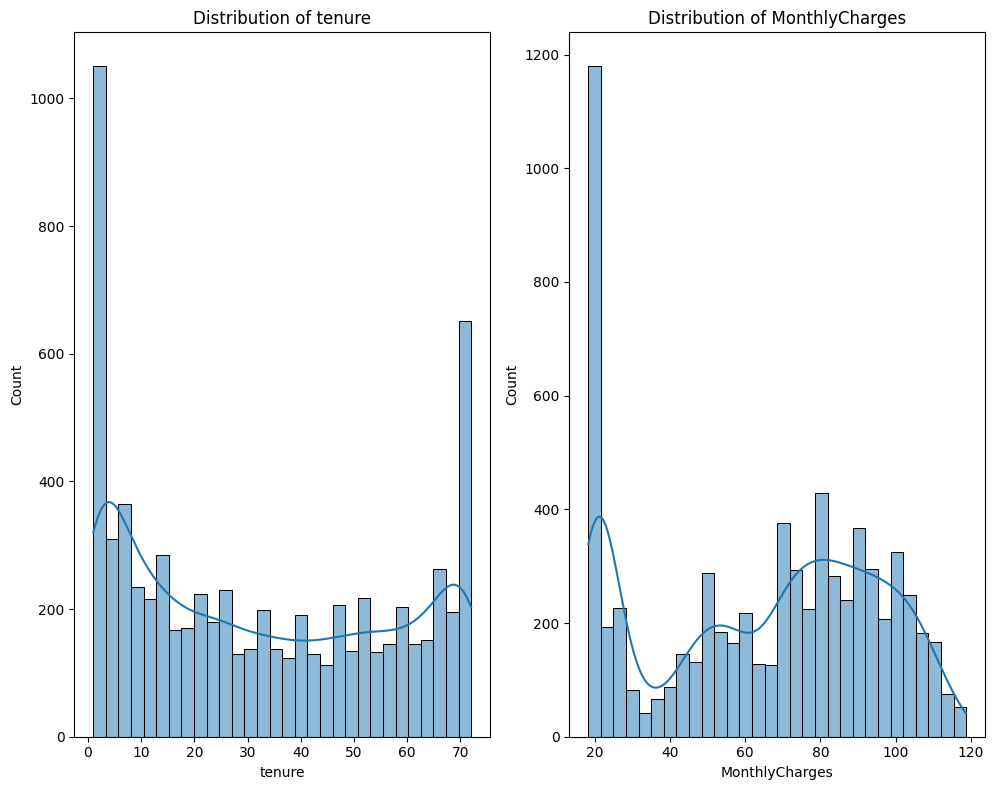

In [11]:
numerical_cols = ['tenure', 'MonthlyCharges']

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


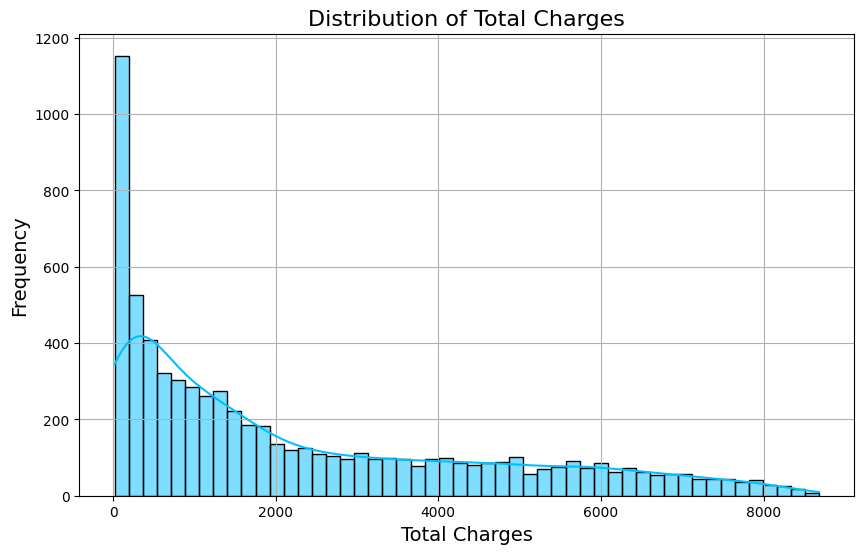

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['TotalCharges'], bins=50, kde=True, color='deepskyblue')

plt.title('Distribution of Total Charges', fontsize=16)
plt.xlabel('Total Charges', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


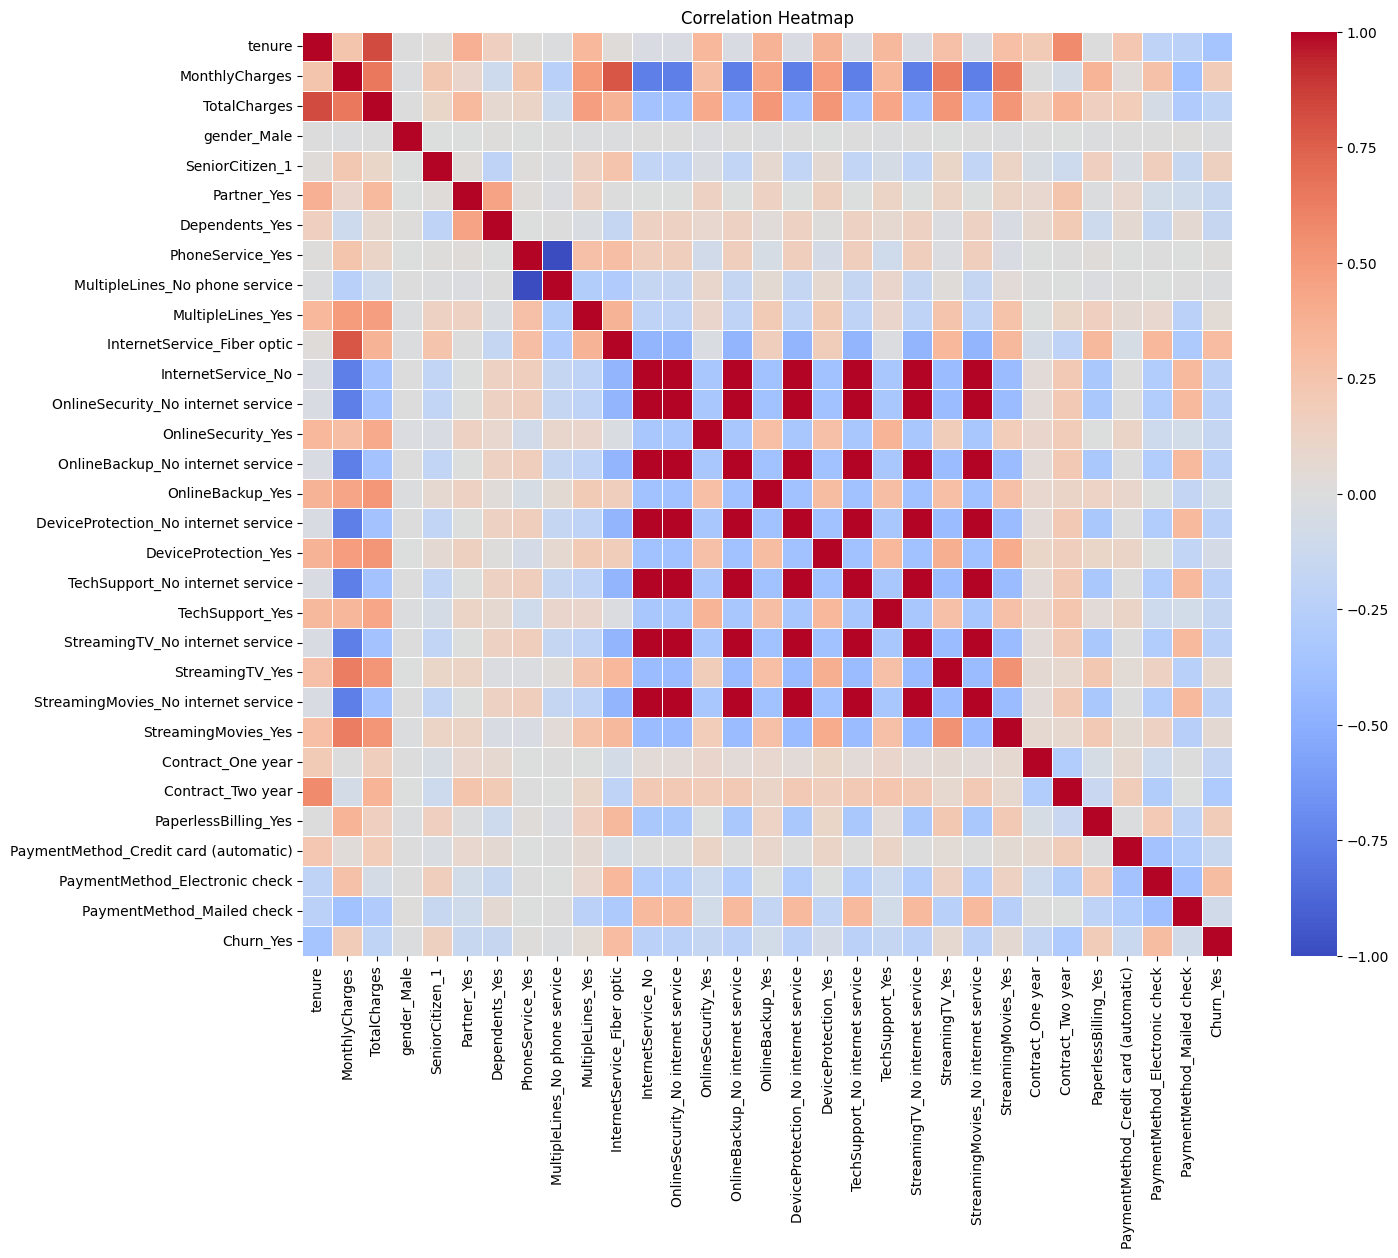

In [13]:
# Convert 'SeniorCitizen' to categorical for correlation
df_corr = df.copy()
df_corr['SeniorCitizen'] = df_corr['SeniorCitizen'].astype('object')
df_corr_encoded = pd.get_dummies(df_corr.drop(['customerID'], axis=1), drop_first=True)

plt.figure(figsize=(15, 12))
corr = df_corr_encoded.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


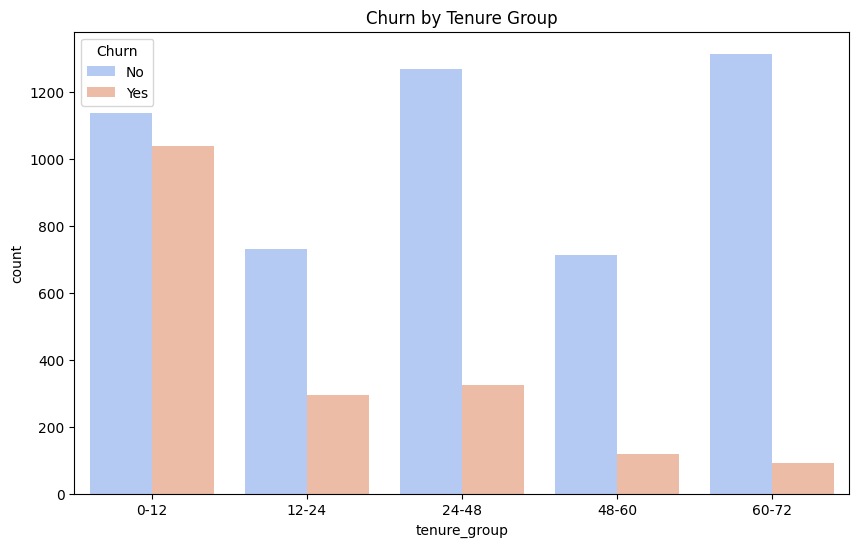

In [14]:
# Create tenure bins
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '12-24', '24-48', '48-60', '60-72'])

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tenure_group', hue='Churn', palette='coolwarm')
plt.title('Churn by Tenure Group')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

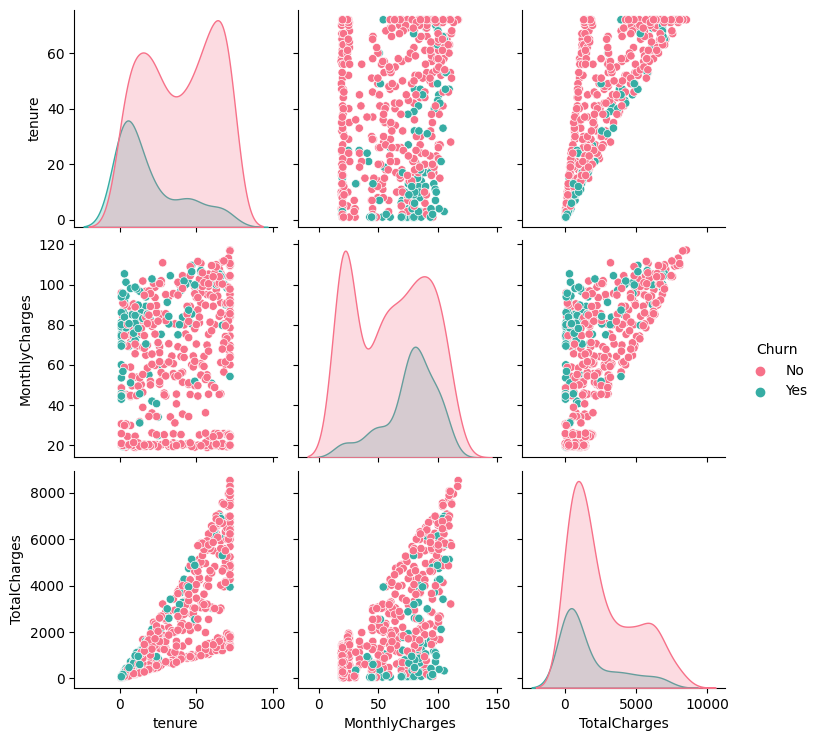

In [15]:
sample_df = df.sample(500, random_state=1)  # Pairplot is heavy, sample for speed
sns.pairplot(sample_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']],
             hue='Churn', palette='husl')
plt.show()


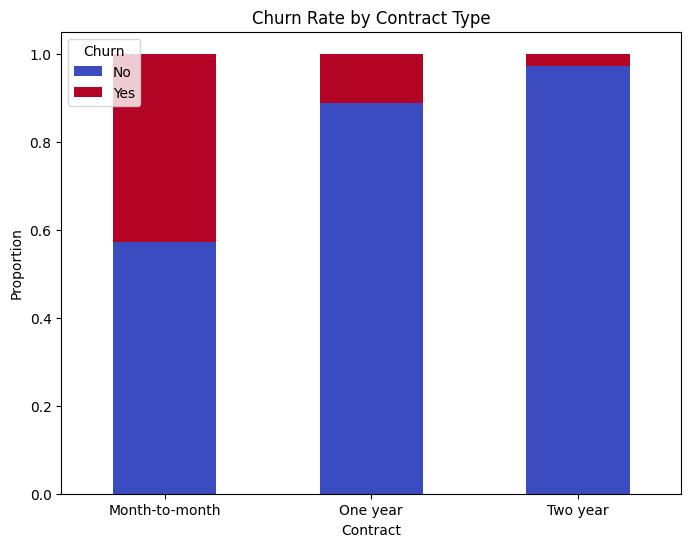

In [16]:
churn_rate = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
churn_rate.plot(kind='bar', stacked=True, figsize=(8,6), colormap='coolwarm')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()


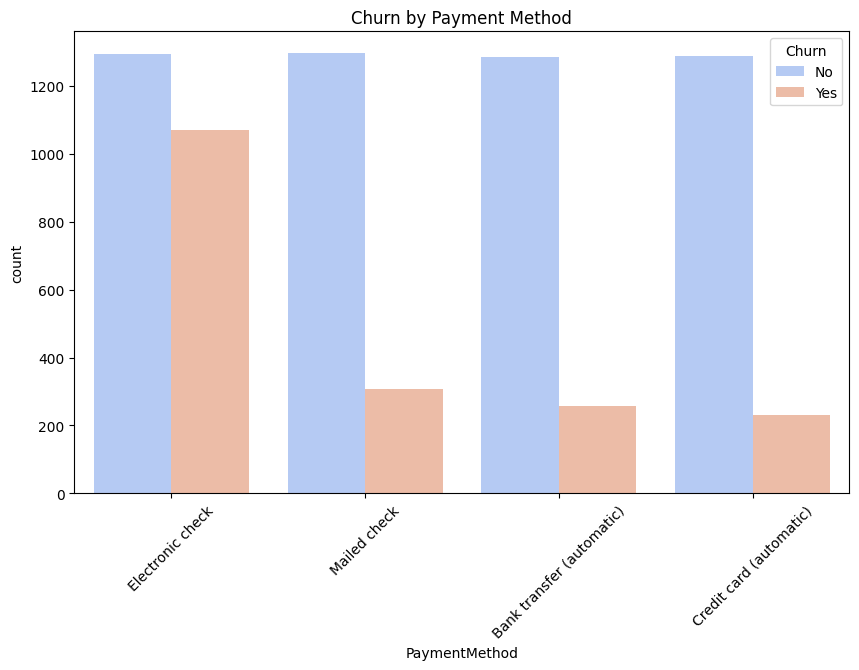

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PaymentMethod', hue='Churn', palette='coolwarm')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)
plt.show()


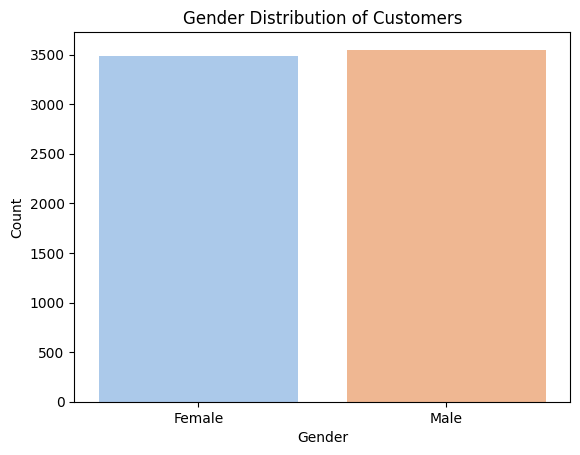

In [18]:
sns.countplot(data=df, x='gender', palette='pastel')
plt.title('Gender Distribution of Customers')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

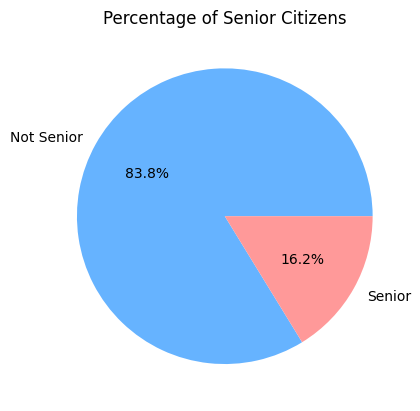

In [19]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

senior_counts = df['SeniorCitizen'].value_counts(normalize=True) * 100
senior_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Not Senior', 'Senior'], colors=['#66b3ff','#ff9999'])
plt.title('Percentage of Senior Citizens')
plt.ylabel('')
plt.show()

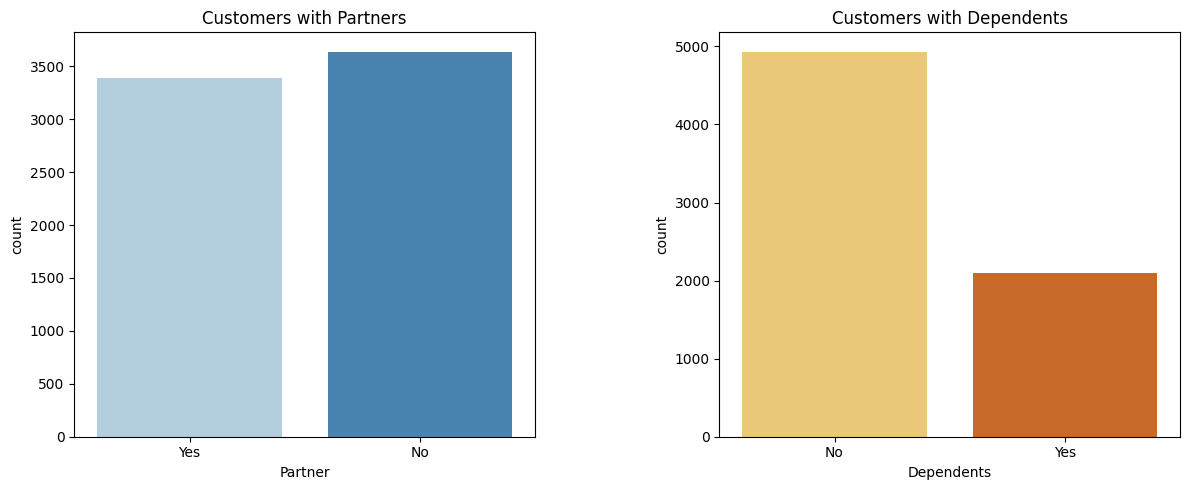

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=df, x='Partner', ax=axes[0], palette='Blues')
axes[0].set_title('Customers with Partners')

sns.countplot(data=df, x='Dependents', ax=axes[1], palette='YlOrBr')
axes[1].set_title('Customers with Dependents')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


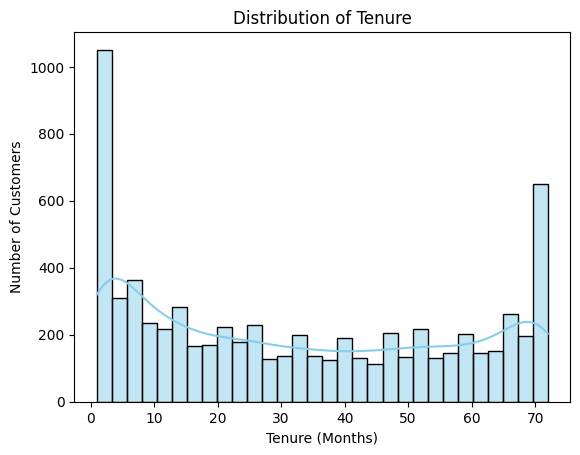

In [21]:
sns.histplot(data=df, x='tenure', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()


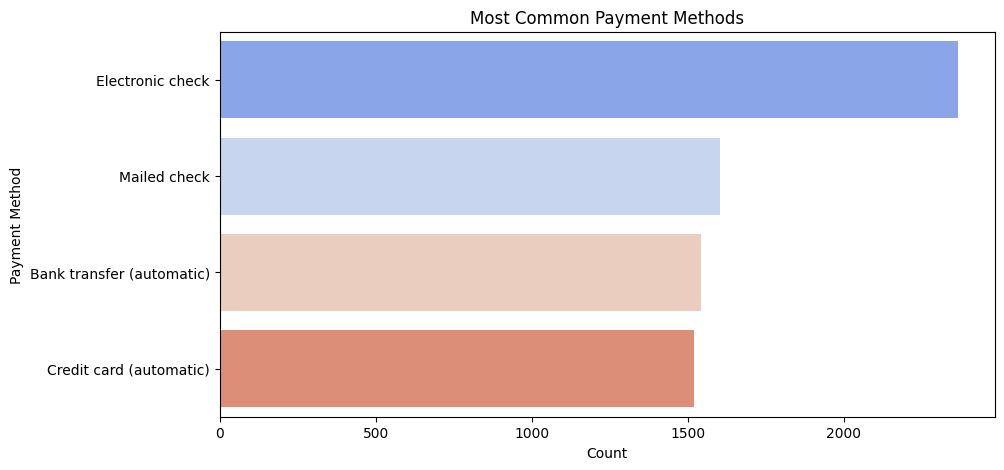

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='PaymentMethod', order=df['PaymentMethod'].value_counts().index, palette='coolwarm')
plt.title('Most Common Payment Methods')
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.show()


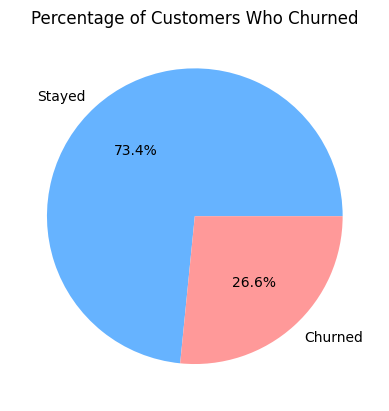

In [23]:
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
churn_percentage.plot(kind='pie', autopct='%1.1f%%', labels=['Stayed', 'Churned'], colors=['#66b3ff','#ff9999'])
plt.title('Percentage of Customers Who Churned')
plt.ylabel('')
plt.show()


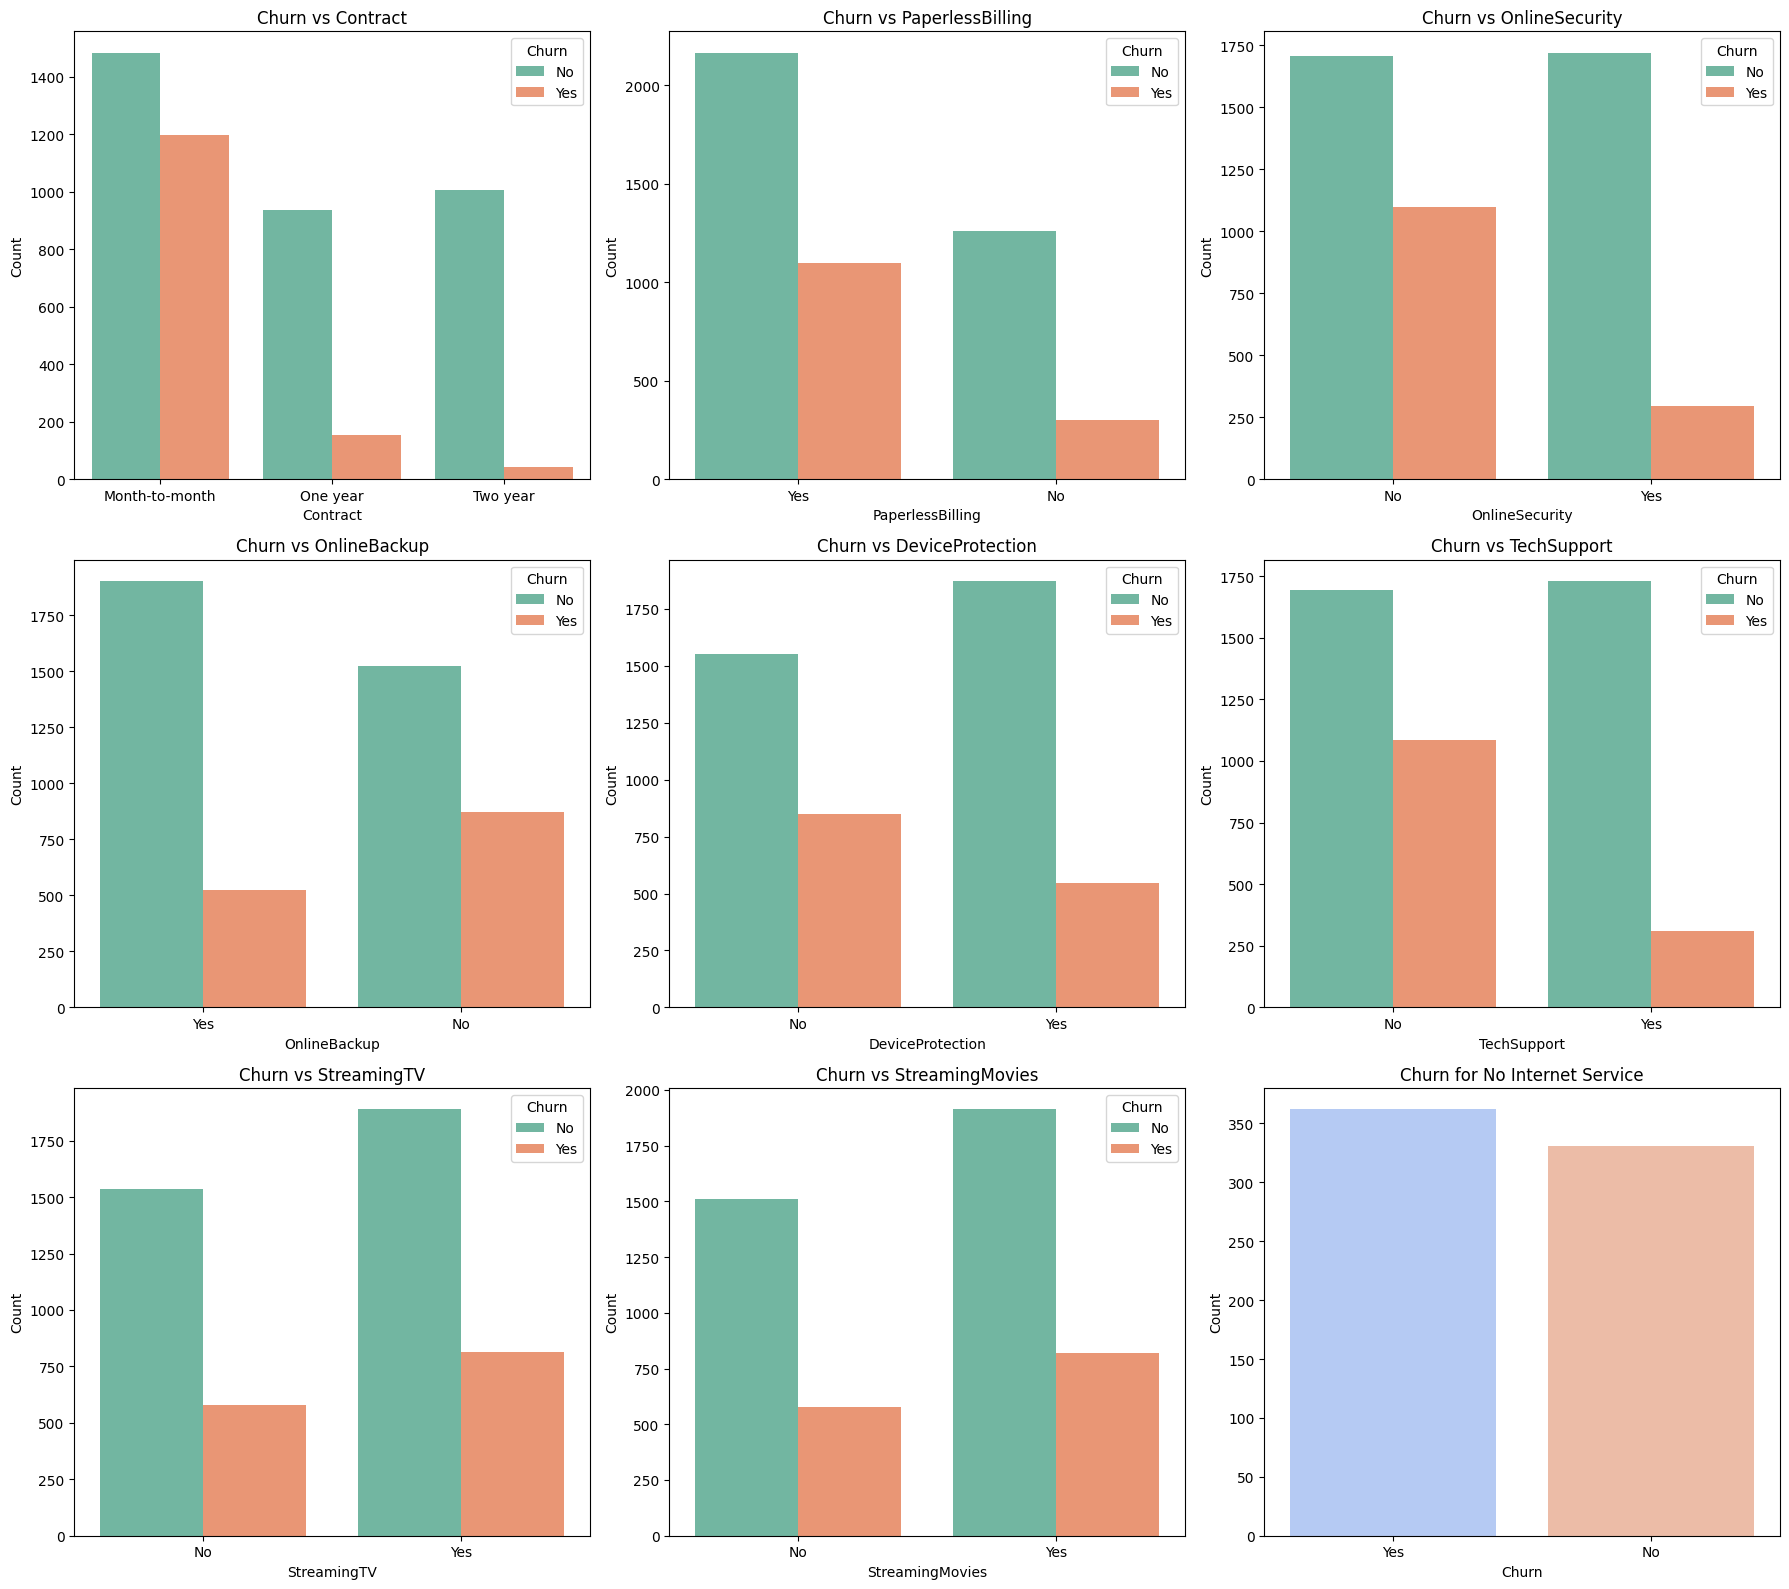

In [24]:
internet_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                            'TechSupport', 'StreamingTV', 'StreamingMovies']


df['No_Internet_Service'] = df[internet_service_columns].apply(lambda row: all(val == 'No' for val in row), axis=1)


df_no_internet = df[df['No_Internet_Service']].copy()
df_with_internet = df[~df['No_Internet_Service']].copy()


for col in internet_service_columns:
    df_with_internet = df_with_internet[df_with_internet[col] != 'No internet service']

service_columns = ['Contract', 'PaperlessBilling'] + internet_service_columns

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

for i, service in enumerate(service_columns):
    sns.countplot(data=df_with_internet, x=service, hue='Churn', ax=axes[i], palette='Set2')
    axes[i].set_title(f'Churn vs {service}')
    axes[i].set_xlabel(service)
    axes[i].set_ylabel('Count')


sns.countplot(data=df_no_internet, x='Churn', ax=axes[-1], palette='coolwarm')
axes[-1].set_title('Churn for No Internet Service')
axes[-1].set_xlabel('Churn')
axes[-1].set_ylabel('Count')


plt.tight_layout()
plt.show()



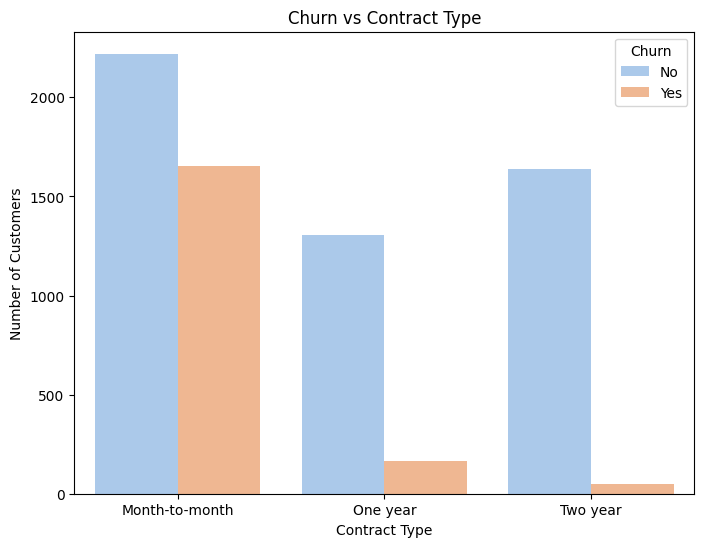

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Contract', hue='Churn', palette='pastel')
plt.title('Churn vs Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()


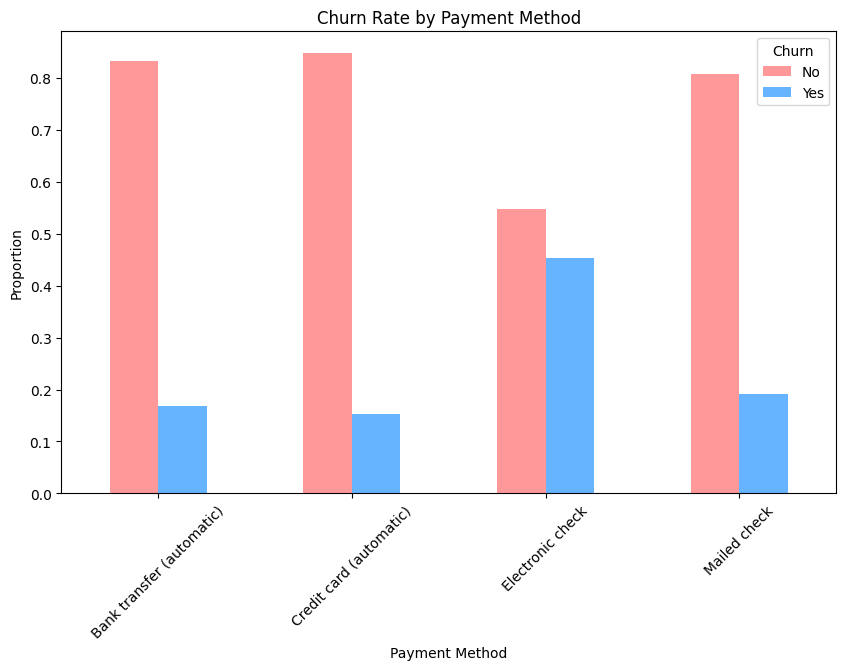

In [26]:
churn_by_payment = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack().reset_index()


churn_by_payment.plot(x='PaymentMethod', kind='bar', stacked=False, color=['#ff9999', '#66b3ff'], figsize=(10, 6))
plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()


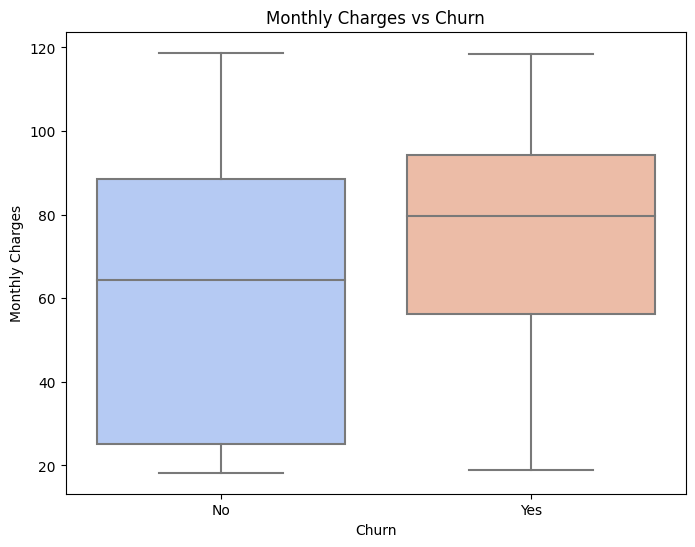

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='coolwarm')
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

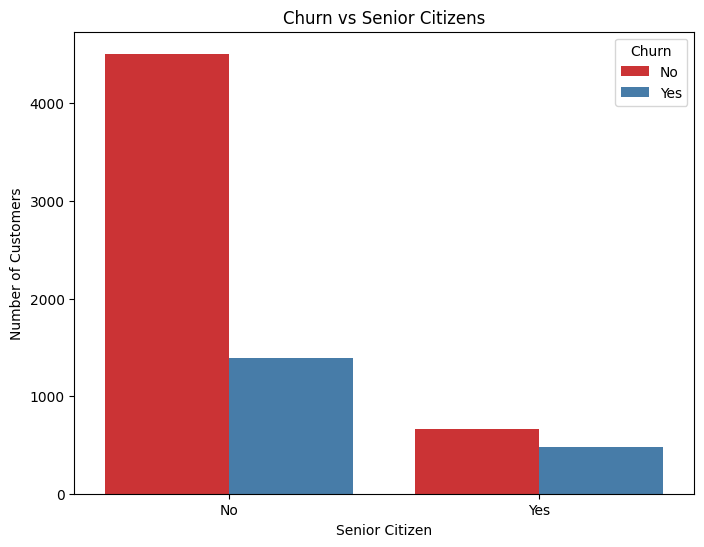

In [28]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')


df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', palette='Set1')
plt.title('Churn vs Senior Citizens')
plt.xlabel('Senior Citizen')
plt.ylabel('Number of Customers')
plt.show()



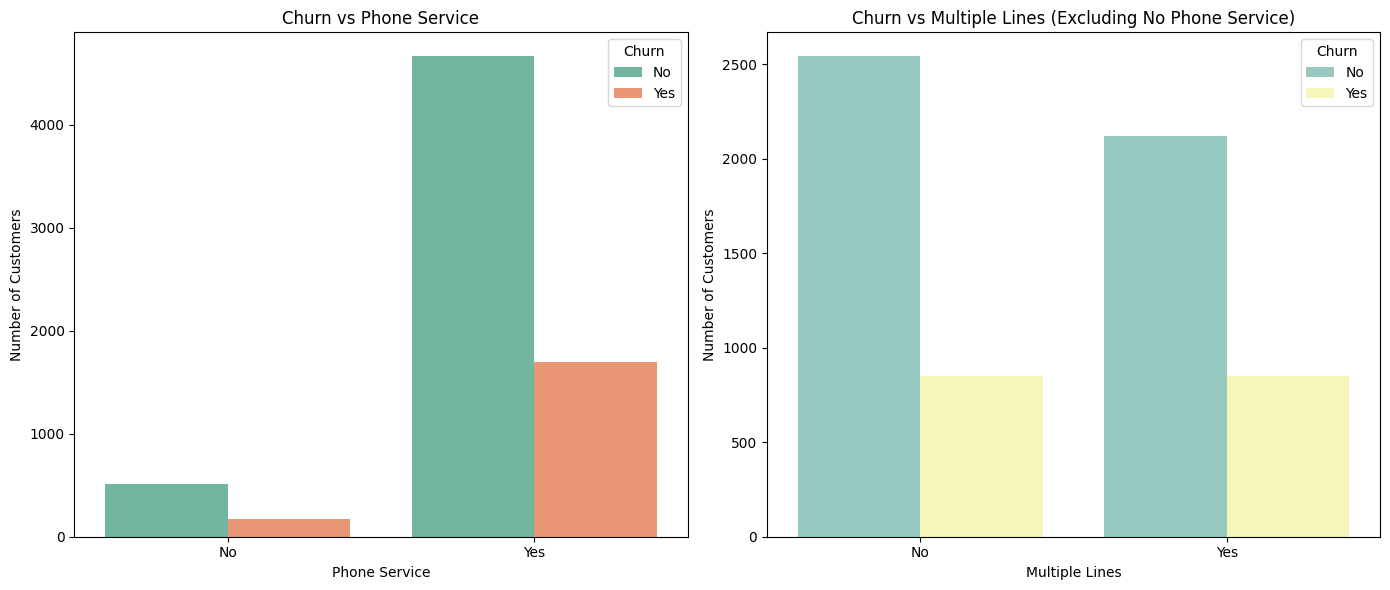

In [29]:
df_filtered = df[df['MultipleLines'] != 'No phone service']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.countplot(data=df, x='PhoneService', hue='Churn', palette='Set2', ax=axes[0])
axes[0].set_title('Churn vs Phone Service')
axes[0].set_xlabel('Phone Service')
axes[0].set_ylabel('Number of Customers')

sns.countplot(data=df_filtered, x='MultipleLines', hue='Churn', palette='Set3', ax=axes[1])
axes[1].set_title('Churn vs Multiple Lines (Excluding No Phone Service)')
axes[1].set_xlabel('Multiple Lines')
axes[1].set_ylabel('Number of Customers')


plt.tight_layout()


plt.show()


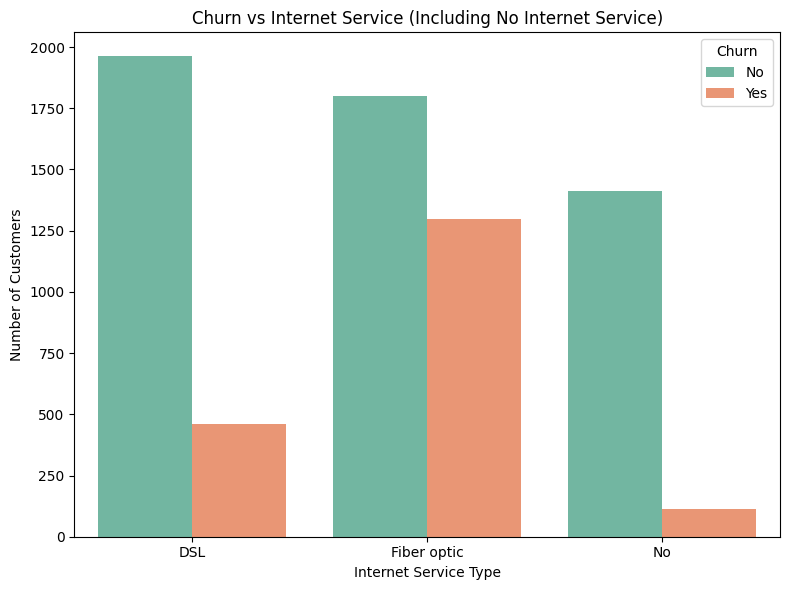

In [30]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='InternetService', hue='Churn', palette='Set2')


plt.title('Churn vs Internet Service (Including No Internet Service)')
plt.xlabel('Internet Service Type')
plt.ylabel('Number of Customers')


plt.tight_layout()
plt.show()


**Data preprocessing**

In [31]:
df.drop("customerID", axis=1 ,inplace =True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [33]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [34]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # coerce => If the data null will put NAN instead of rease error

In [35]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


**feature engineering**

Tenure Group

In [36]:
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'
    
df['TenureGroup'] = df['tenure'].apply(tenure_group)

TotalCharges per Tenure

In [37]:
df['ChargesPerMonth'] = df['TotalCharges'] / df['tenure']

Contract and PaymentMethod

In [38]:
df['Contract_PaymentInteraction'] = df['Contract'] + '_' + df['PaymentMethod']

Has Phone And Internet

In [39]:
df['HasPhoneAndInternet'] = np.where((df['PhoneService'] == 'Yes') & (df['InternetService'] != 'No'), 1, 0)

Number of services

In [40]:
df['NumServices'] = ((df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                         'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                         'StreamingMovies']] == 'Yes') |
                          (df['InternetService'].isin(['DSL', 'Fiber optic']))).sum(axis=1)

In [41]:
df.isnull().sum()

gender                          0
SeniorCitizen                   0
Partner                         0
Dependents                      0
tenure                          0
PhoneService                    0
MultipleLines                   0
InternetService                 0
OnlineSecurity                  0
OnlineBackup                    0
DeviceProtection                0
TechSupport                     0
StreamingTV                     0
StreamingMovies                 0
Contract                        0
PaperlessBilling                0
PaymentMethod                   0
MonthlyCharges                  0
TotalCharges                   11
Churn                           0
TenureGroup                     0
ChargesPerMonth                11
Contract_PaymentInteraction     0
HasPhoneAndInternet             0
NumServices                     0
dtype: int64

In [42]:
null_columns = df.isna().sum()
null_columns = null_columns[null_columns > 0] # Catch row which has null values
print(null_columns)

TotalCharges       11
ChargesPerMonth    11
dtype: int64


In [43]:
list_of_non_numerical = df.select_dtypes(exclude=['int64', 'float64']).columns # Catch categecores coulumns
print("Non-numerical columns in training set:", list(list_of_non_numerical))

Non-numerical columns in training set: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'TenureGroup', 'Contract_PaymentInteraction']


lebelencoder

In [44]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in list_of_non_numerical:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

Filling Missing Values Using Euclidean Distance

In [45]:
from sklearn.metrics.pairwise import euclidean_distances
def fill_missing_values(data_f, null_column):
    cols = list(data_f.columns.difference([null_column])) # all compelete coulmns names
    non_missing_df = data_f.dropna(subset=[null_column]) # df without nulls
    missing_df = data_f[data_f[null_column].isna()] # df which has null

    # If no missing will continue 
    if missing_df.empty or non_missing_df.empty:
        return

    distance = euclidean_distances(non_missing_df[cols].fillna(0), missing_df[cols].fillna(0)) # get simmiler rows
    nearest_index = np.argmin(distance, axis=0)
    
    data_f.loc[data_f[null_column].isna(), null_column] = non_missing_df.iloc[nearest_index][null_column].values # Filling the null values

In [46]:
for col in list(null_columns.index):
    fill_missing_values(df, col)

In [47]:
print("Remaining missing values in training set:\n", df.isna().sum())

Remaining missing values in training set:
 gender                         0
SeniorCitizen                  0
Partner                        0
Dependents                     0
tenure                         0
PhoneService                   0
MultipleLines                  0
InternetService                0
OnlineSecurity                 0
OnlineBackup                   0
DeviceProtection               0
TechSupport                    0
StreamingTV                    0
StreamingMovies                0
Contract                       0
PaperlessBilling               0
PaymentMethod                  0
MonthlyCharges                 0
TotalCharges                   0
Churn                          0
TenureGroup                    0
ChargesPerMonth                0
Contract_PaymentInteraction    0
HasPhoneAndInternet            0
NumServices                    0
dtype: int64


**modeling**

In [53]:
X = df.drop('Churn', axis=1)
y = df['Churn']


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
X = scaler.fit_transform(X)

**Random forrest classifier**

In [57]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print(study.best_params)

[I 2025-05-13 11:16:28,478] A new study created in memory with name: no-name-41c4d136-7911-470c-9b4c-1c809f2ea148
[I 2025-05-13 11:16:36,564] Trial 0 finished with value: 0.7975659229208925 and parameters: {'n_estimators': 327, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.7975659229208925.
[I 2025-05-13 11:16:48,855] Trial 1 finished with value: 0.7967545638945233 and parameters: {'n_estimators': 414, 'max_depth': 38, 'min_samples_split': 18, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7975659229208925.
[I 2025-05-13 11:16:52,754] Trial 2 finished with value: 0.7981744421906695 and parameters: {'n_estimators': 135, 'max_depth': 48, 'min_samples_split': 19, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 2 with value: 0.7981744421906695.
[I 2025-05-13 11:16:59,680] Trial 3 finished with value: 0.7922920892494929 and parameters: {'n_estimators': 218, 'max_depth': 45, 'min_samples

{'n_estimators': 488, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 10, 'bootstrap': True}


gridsearchcv

In [58]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

forest_model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=forest_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred_forest = best_model.predict(X_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total 

In [59]:
print(best_params)
print(best_model) 
print(accuracy_score(y_test, y_pred_forest))

{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50)
0.7908187411263606


In [60]:
forest_model = RandomForestClassifier(class_weight='balanced', bootstrap= False, max_depth= 26, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 250)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
y_prob_forest = forest_model.predict_proba(X_test)[:, 1]

fpr_forest, tpr_forest, _ = roc_curve(y_test, y_prob_forest)
roc_auc_forest = auc(fpr_forest, tpr_forest)

print("Random Forest MODEL")
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_forest))

Random Forest MODEL
Accuracy: 0.7875059157595835
ROC-AUC: 0.8270223888537966


evaluation

classification report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1539
           1       0.63      0.51      0.57       574

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



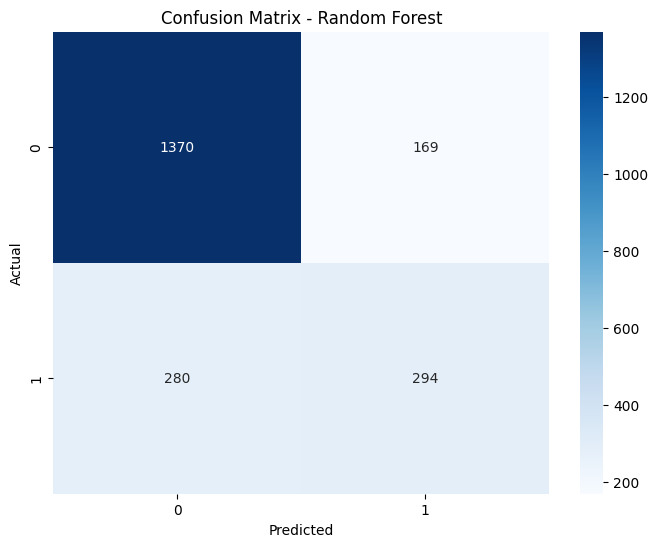

In [61]:
print("classification report")
print(classification_report(y_test, y_pred_forest))
cm = confusion_matrix(y_test, y_pred_forest)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_forest, y=tpr_forest,
    mode='lines',
    line=dict(color='purple', width=2),
    name=f'ROC Curve (AUC = {roc_auc_forest:.2f})'
))
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='gray', width=2, dash='dash'),
    name='Random'
))
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve - Random Forest',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_dark'
)
fig.show()

XGboost

In [64]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

print("XGBOOST MODEL")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
XGBOOST MODEL
Accuracy: 0.8054898248935163
ROC-AUC: 0.8559502867376209


evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.69      0.52      0.59       574

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113



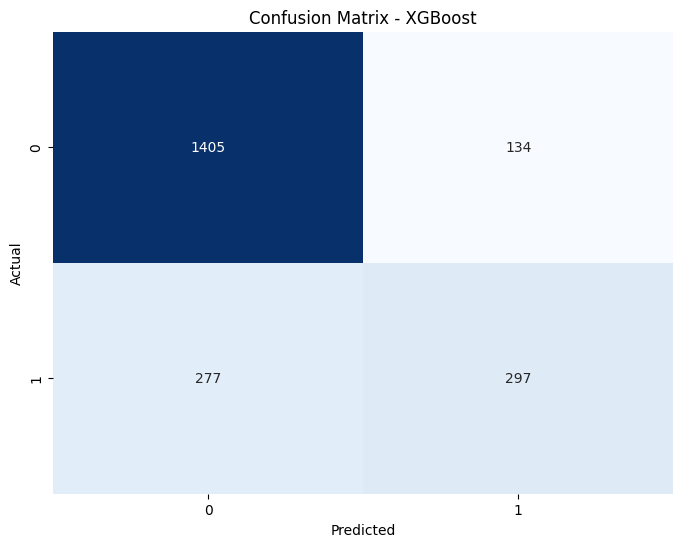

In [65]:
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [66]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr, y=tpr,
    mode='lines',
    line=dict(color='red', width=2),
    name='ROC Curve'
))
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='White', width=2, dash='dash'),
    name='Random'
))
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_dark'
)
fig.show()

logistic regression

In [67]:
log_model = LogisticRegression(solver="liblinear" , random_state=1)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

print("Logistic Regression MODEL")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

Logistic Regression MODEL
Accuracy: 0.8088026502602934
ROC-AUC: 0.8577552734591672


evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.67      0.57      0.62       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.75      2113
weighted avg       0.80      0.81      0.80      2113



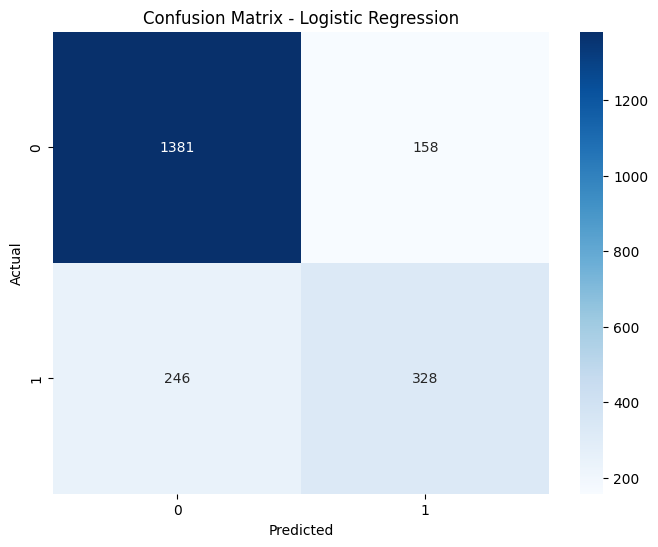

In [68]:
print("Classification Report")
print(classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_log, y=tpr_log,
    mode='lines',
    line=dict(color='orange', width=2),
    name=f'ROC Curve (AUC = {roc_auc_log:.2f})'
))
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='White', width=2, dash='dash'),
    name='Random'
))
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_dark'
)
fig.show()

Decision Tree Model

In [70]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)

print("Decision Tree MODEL")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_tree))

Decision Tree MODEL
Accuracy: 0.7236157122574538
ROC-AUC: 0.6524661925817253


evaluation

classification report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1539
           1       0.49      0.50      0.49       574

    accuracy                           0.72      2113
   macro avg       0.65      0.65      0.65      2113
weighted avg       0.72      0.72      0.72      2113



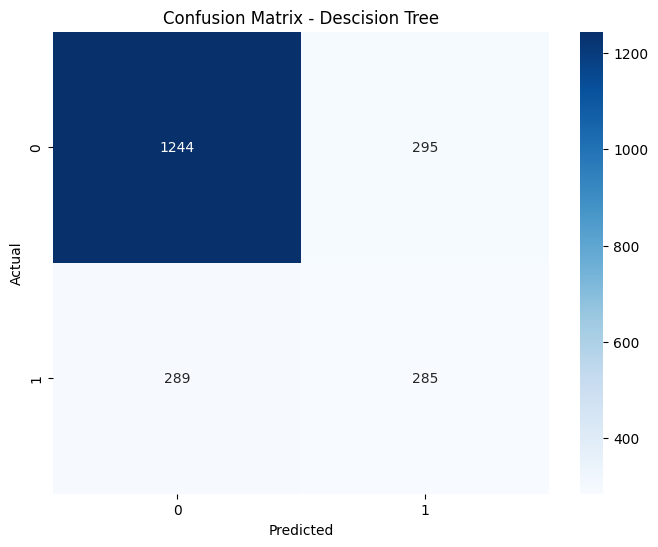

In [71]:
print("classification report")
print(classification_report(y_test, y_pred_tree))
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Descision Tree')
plt.show()

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_tree, y=tpr_tree,
    mode='lines',
    line=dict(color='green', width=2),
    name=f'ROC Curve (AUC = {roc_auc_tree:.2f})'
))
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='White', width=2, dash='dash'),
    name='Random'
))
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_dark'
)
fig.show()

**Comparison Between Models Accuracy and ROC Score**

In [73]:
models = ['XGBoost', 'Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_log),
    accuracy_score(y_test, y_pred_tree),
    accuracy_score(y_test, y_pred_forest)
]
fig_acc = go.Figure()
fig_acc.add_trace(go.Bar(
    x=models,
    y=accuracies,
    marker_color='royalblue',
    text=[f'{acc:.2f}' for acc in accuracies],
    textposition='auto'
))
fig_acc.update_layout(
    title='Model Accuracy Comparison',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    template='plotly_dark'
)
fig_acc.show()

In [74]:
roc_auc_scores = [
    roc_auc_score(y_test, y_prob_xgb),
    roc_auc_score(y_test, y_prob_log),
    roc_auc_score(y_test, y_prob_tree),
    roc_auc_score(y_test, y_prob_forest)
]
fig_auc = go.Figure()
fig_auc.add_trace(go.Bar(
    x=models,
    y=roc_auc_scores,
    marker_color='darkorange',
    text=[f'{auc:.2f}' for auc in roc_auc_scores],
    textposition='auto'
))
fig_auc.update_layout(
    title='Model ROC-AUC Comparison',
    xaxis_title='Model',
    yaxis_title='ROC-AUC Score',
    template='plotly_dark'
)
fig_auc.show()


[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.7s
[CV] END bootstrap=False, max_depth=30, min_samples_l